<a href="https://colab.research.google.com/github/MrShiroLu/Kimya-Tesisinde-Reaksiyon-Suresi-ve-Sicaklik-Ayari/blob/main/Kimya_Tesisinde_Reaksiyon_S%C3%BCresi_ve_S%C4%B1cakl%C4%B1k_Ayar%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ad: Burak
Soyad: ARTUN
Okul Numarası: 2312729005
GitHub Repo Bağlantısı: https://github.com/MrShiroLu/Kimya-Tesisinde-Reaksiyon-Suresi-ve-Sicaklik-Ayari

# Kimya Tesisinde Reaksiyon Süresi ve Sıcaklık Ayarı

## Problem Tanımı

Kimyasal üretimde reaksiyon süresi ve sıcaklık ayarı sonucu verimi etkiliyor.

### Amaç Fonksiyonu
$$y = 8x_1 + 3x_2 - x_1x_2 + x_1^2$$

### Değişkenler
- $x_1$: Reaksiyon süresi (dk) → [10, 60]
- $x_2$: Sıcaklık (°C) → [40, 120]

### Kısıtlar
- $x_1 + x_2 \leq 140$
- $x_2 \geq 60$

## 1. Gerekli Kütüphaneler

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Türkçe desteği
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

## 2. Amaç Fonksiyonları ve Kısıtları Tanımlama

In [ ]:
def objective_function(x):
    """
    Reaksiyon verimi fonksiyonu
    y = 8x1 + 3x2 - x1*x2 + x1^2

    Parametreler:
    x[0] = x1 : Reaksiyon süresi (dk)
    x[1] = x2 : Sıcaklık (derece C)
    """
    x1, x2 = x[0], x[1]
    return 8*x1 + 3*x2 - x1*x2 + x1**2

def objective_function_minimization(x):
    """
    Maksimizasyon için negatif değer döndürür
    (scipy.minimize fonksiyonu minimize ettiği için)
    """
    return -objective_function(x)

# Değişken sınırları
bounds = [
    (10, 60),   # x1: Reaksiyon süresi (dk)
    (40, 120)   # x2: Sıcaklık (°C)
]

# Kısıtlar (scipy için format)
# x1 + x2 ≤ 140  →  140 - x1 - x2 ≥ 0
# x2 ≥ 60  →  x2 - 60 ≥ 0

constraints = [
    {'type': 'ineq', 'fun': lambda x: 140 - x[0] - x[1]},  # x1 + x2 ≤ 140
    {'type': 'ineq', 'fun': lambda x: x[1] - 60}           # x2 ≥ 60
]

print("Değişken Sınırları:")
print(f"  x1 (Reaksiyon süresi): [{bounds[0][0]}, {bounds[0][1]}] dk")
print(f"  x2 (Sıcaklık): [{bounds[1][0]}, {bounds[1][1]}] derece C")
print("\nKısıtlar:")
print("  1. x1 + x2 ≤ 140")
print("  2. x2 ≥ 60")

Değişken Sınırları:
  x1 (Reaksiyon süresi): [10, 60] dk
  x2 (Sıcaklık): [40, 120] derece C

Kısıtlar:
  1. x1 + x2 ≤ 140
  2. x2 ≥ 60


## 3. Optimizasyon Çözümü

In [ ]:
# Başlangıç noktası
x0 = [35, 80]  # Orta değerlerden başlayalım

# SLSQP (Sequential Least SQuares Programming) yöntemi ile optimizasyon
result_slsqp = minimize(
    objective_function_minimization,
    x0,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

print("="*60)
print("SLSQP Yöntemi Sonuçları")
print("="*60)
print(f"Optimizasyon Durumu: {result_slsqp.message}")
print(f"Başarılı mı: {result_slsqp.success}")
print(f"\nOptimal Değerler:")
print(f"  x1 (Reaksiyon süresi): {result_slsqp.x[0]:.4f} dk")
print(f"  x2 (Sıcaklık): {result_slsqp.x[1]:.4f} derece C")
print(f"\nMaksimum Verim: {-result_slsqp.fun:.4f}")
print(f"İterasyon Sayısı: {result_slsqp.nit}")

# Kısıtları kontrol edelim
print("\nKısıt Kontrolleri:")
print(f"  x1 + x2 = {result_slsqp.x[0] + result_slsqp.x[1]:.4f} (≤ 140? {result_slsqp.x[0] + result_slsqp.x[1] <= 140})")
print(f"  x2 = {result_slsqp.x[1]:.4f} (≥ 60? {result_slsqp.x[1] >= 60})")

SLSQP Yöntemi Sonuçları
Optimizasyon Durumu: Optimization terminated successfully
Başarılı mı: True

Optimal Değerler:
  x1 (Reaksiyon süresi): 60.0000 dk
  x2 (Sıcaklık): 60.0000 derece C

Maksimum Verim: 660.0000
İterasyon Sayısı: 5

Kısıt Kontrolleri:
  x1 + x2 = 120.0000 (≤ 140? True)
  x2 = 60.0000 (≥ 60? False)


## 4. Differential Evolution ile Alternatif Çözüm

In [ ]:
# Differential Evolution için kısıt fonksiyonu
def constraint_penalty(x):
    """Kısıt ihlali varsa büyük bir ceza döndürür"""
    penalty = 0

    # x1 + x2 ≤ 140
    if x[0] + x[1] > 140:
        penalty += 1e6 * (x[0] + x[1] - 140)

    # x2 ≥ 60
    if x[1] < 60:
        penalty += 1e6 * (60 - x[1])

    return penalty

def objective_with_penalty(x):
    return objective_function_minimization(x) + constraint_penalty(x)

# Differential Evolution ile optimizasyon
result_de = differential_evolution(
    objective_with_penalty,
    bounds,
    seed=42,
    maxiter=1000
)

print("="*60)
print("Differential Evolution Yöntemi Sonuçları")
print("="*60)
print(f"Optimizasyon Durumu: {result_de.message}")
print(f"Başarılı mı: {result_de.success}")
print(f"\nOptimal Değerler:")
print(f"  x1 (Reaksiyon süresi): {result_de.x[0]:.4f} dk")
print(f"  x2 (Sıcaklık): {result_de.x[1]:.4f} derece C")
print(f"\nMaksimum Verim: {-result_de.fun:.4f}")
print(f"Fonksiyon Değerlendirme Sayısı: {result_de.nfev}")

# Kısıtları kontrol edelim
print("\nKısıt Kontrolleri:")
print(f"  x1 + x2 = {result_de.x[0] + result_de.x[1]:.4f} (≤ 140? {result_de.x[0] + result_de.x[1] <= 140})")
print(f"  x2 = {result_de.x[1]:.4f} (≥ 60? {result_de.x[1] >= 60})")

Differential Evolution Yöntemi Sonuçları
Optimizasyon Durumu: Optimization terminated successfully.
Başarılı mı: True

Optimal Değerler:
  x1 (Reaksiyon süresi): 59.9917 dk
  x2 (Sıcaklık): 60.0010 derece C

Maksimum Verim: 659.3824
Fonksiyon Değerlendirme Sayısı: 903

Kısıt Kontrolleri:
  x1 + x2 = 119.9927 (≤ 140? True)
  x2 = 60.0010 (≥ 60? True)


## 5. Sonuçların Karşılaştırılması

In [ ]:
# En iyi sonucu seçelim
best_result = result_slsqp if -result_slsqp.fun > -result_de.fun else result_de
best_method = "SLSQP" if -result_slsqp.fun > -result_de.fun else "Differential Evolution"

print("="*60)
print("SONUÇ ÖZETİ")
print("="*60)
print(f"\nEn İyi Yöntem: {best_method}")
print(f"\nOptimal Çalışma Koşulları:")
print(f"  • Reaksiyon Süresi: {best_result.x[0]:.2f} dakika")
print(f"  • Sıcaklık: {best_result.x[1]:.2f} derece C")
print(f"\nMaksimum Reaksiyon Verimi: {-best_result.fun:.2f}")
print("\n" + "="*60)

# İki yöntemin karşılaştırması
comparison_data = {
    'Yöntem': ['SLSQP', 'Differential Evolution'],
    'x1 (dk)': [result_slsqp.x[0], result_de.x[0]],
    'x2 (derece C)': [result_slsqp.x[1], result_de.x[1]],
    'Verim': [-result_slsqp.fun, -result_de.fun]
}

df_comparison = pd.DataFrame(comparison_data)
print("\nYöntem Karşılaştırması:")
print(df_comparison.to_string(index=False))

SONUÇ ÖZETİ

En İyi Yöntem: SLSQP

Optimal Çalışma Koşulları:
  • Reaksiyon Süresi: 60.00 dakika
  • Sıcaklık: 60.00 derece C

Maksimum Reaksiyon Verimi: 660.00


Yöntem Karşılaştırması:
                Yöntem   x1 (dk)  x2 (derece C)      Verim
                 SLSQP 60.000000      60.000000 660.000000
Differential Evolution 59.991713      60.000951 659.382371


## 6. Görselleştirme

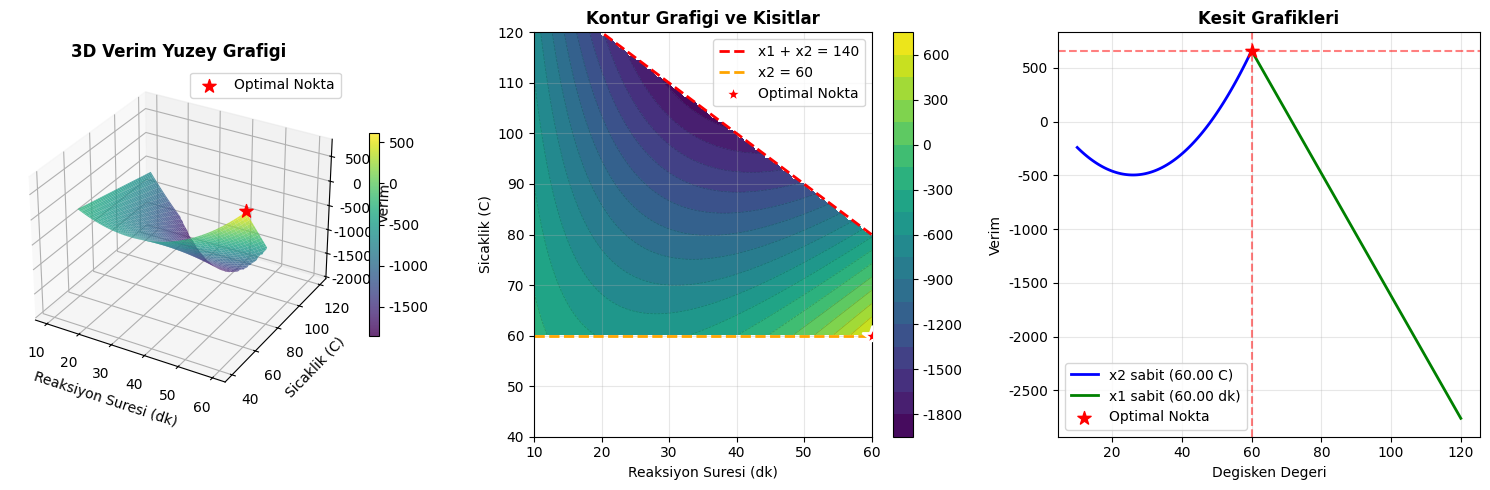

In [ ]:
# Amaç fonksiyonunun 3D görselleştirmesi
x1_range = np.linspace(10, 60, 100)
x2_range = np.linspace(40, 120, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
Y = 8*X1 + 3*X2 - X1*X2 + X1**2

# Kısıtları ihlal eden bölgeleri maskeleme
# x1 + x2 ≤ 140 ve x2 ≥ 60
mask = (X1 + X2 > 140) | (X2 < 60)
Y_masked = np.ma.array(Y, mask=mask)

fig = plt.figure(figsize=(15, 5))

# 3D Yüzey grafiği
ax1 = fig.add_subplot(131, projection='3d')
surf = ax1.plot_surface(X1, X2, Y_masked, cmap='viridis', alpha=0.8)
ax1.scatter([best_result.x[0]], [best_result.x[1]], [-best_result.fun],
            color='red', s=100, marker='*', label='Optimal Nokta')
ax1.set_xlabel('Reaksiyon Suresi (dk)', fontsize=10)
ax1.set_ylabel('Sicaklik (C)', fontsize=10)
ax1.set_zlabel('Verim', fontsize=10)
ax1.set_title('3D Verim Yuzey Grafigi', fontsize=12, fontweight='bold')
ax1.legend()
fig.colorbar(surf, ax=ax1, shrink=0.5)

# Kontur grafiği
ax2 = fig.add_subplot(132)
contour = ax2.contourf(X1, X2, Y_masked, levels=20, cmap='viridis')
ax2.contour(X1, X2, Y_masked, levels=20, colors='black', alpha=0.2, linewidths=0.5)

# Kısıtları çizme
x1_constraint = np.linspace(10, 60, 100)
x2_constraint1 = 140 - x1_constraint  # x1 + x2 = 140
ax2.plot(x1_constraint, x2_constraint1, 'r--', linewidth=2, label='x1 + x2 = 140')
ax2.axhline(y=60, color='orange', linestyle='--', linewidth=2, label='x2 = 60')

# Optimal noktayı işaretleme
ax2.scatter([best_result.x[0]], [best_result.x[1]],
            color='red', s=200, marker='*', zorder=5,
            edgecolors='white', linewidths=2, label='Optimal Nokta')

ax2.set_xlabel('Reaksiyon Suresi (dk)', fontsize=10)
ax2.set_ylabel('Sicaklik (C)', fontsize=10)
ax2.set_title('Kontur Grafigi ve Kisitlar', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(10, 60)
ax2.set_ylim(40, 120)
fig.colorbar(contour, ax=ax2)

# Kesit grafikleri
ax3 = fig.add_subplot(133)

# x2 sabit tutarak x1'e göre değişim
x1_cross = np.linspace(10, 60, 100)
x2_fixed = best_result.x[1]
y_cross1 = 8*x1_cross + 3*x2_fixed - x1_cross*x2_fixed + x1_cross**2

# x1 sabit tutarak x2'ye göre değişim
x2_cross = np.linspace(60, 120, 100)
x1_fixed = best_result.x[0]
y_cross2 = 8*x1_fixed + 3*x2_cross - x1_fixed*x2_cross + x1_fixed**2

ax3.plot(x1_cross, y_cross1, 'b-', linewidth=2,
         label=f'x2 sabit ({x2_fixed:.2f} C)')
ax3.plot(x2_cross, y_cross2, 'g-', linewidth=2,
         label=f'x1 sabit ({x1_fixed:.2f} dk)')
ax3.axvline(x=best_result.x[0], color='red', linestyle='--', alpha=0.5)
ax3.axhline(y=-best_result.fun, color='red', linestyle='--', alpha=0.5)
ax3.scatter([best_result.x[0]], [-best_result.fun],
            color='red', s=100, marker='*', zorder=5, label='Optimal Nokta')

ax3.set_xlabel('Degisken Degeri', fontsize=10)
ax3.set_ylabel('Verim', fontsize=10)
ax3.set_title('Kesit Grafikleri', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

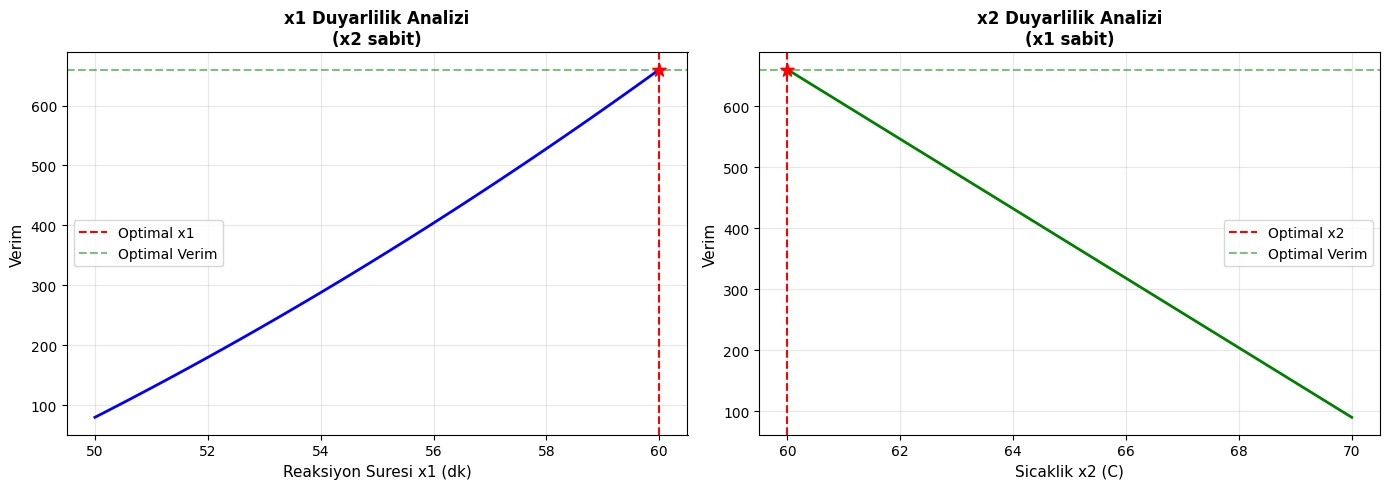


Duyarlılık Analizi Sonuçları:
x1'de -5 dk azalış → Verim değişimi: -47.73%
x2'de +5 derece C artış → Verim değişimi: -43.18%


In [ ]:
# Optimal noktanın etrafında değerler oluştur
optimal_x1 = best_result.x[0]
optimal_x2 = best_result.x[1]
optimal_y = -best_result.fun

# x1 değişimi (±10 dk)
x1_sensitivity = np.linspace(max(10, optimal_x1-10), min(60, optimal_x1+10), 50)
y_sensitivity_x1 = []
for x1 in x1_sensitivity:
    if x1 + optimal_x2 <= 140:  # Kısıt kontrolü
        y_sensitivity_x1.append(objective_function([x1, optimal_x2]))
    else:
        y_sensitivity_x1.append(np.nan)

# x2 değişimi (±10 derece C)
x2_sensitivity = np.linspace(max(60, optimal_x2-10), min(120, optimal_x2+10), 50)
y_sensitivity_x2 = []
for x2 in x2_sensitivity:
    if optimal_x1 + x2 <= 140 and x2 >= 60:  # Kısıt kontrolü
        y_sensitivity_x2.append(objective_function([optimal_x1, x2]))
    else:
        y_sensitivity_x2.append(np.nan)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# x1 duyarlılık grafiği
ax1.plot(x1_sensitivity, y_sensitivity_x1, 'b-', linewidth=2)
ax1.axvline(x=optimal_x1, color='red', linestyle='--', label='Optimal x1')
ax1.axhline(y=optimal_y, color='green', linestyle='--', alpha=0.5, label='Optimal Verim')
ax1.scatter([optimal_x1], [optimal_y], color='red', s=100, marker='*', zorder=5)
ax1.set_xlabel('Reaksiyon Suresi x1 (dk)', fontsize=11)
ax1.set_ylabel('Verim', fontsize=11)
ax1.set_title('x1 Duyarlilik Analizi\n(x2 sabit)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# x2 duyarlılık grafiği
ax2.plot(x2_sensitivity, y_sensitivity_x2, 'g-', linewidth=2)
ax2.axvline(x=optimal_x2, color='red', linestyle='--', label='Optimal x2')
ax2.axhline(y=optimal_y, color='green', linestyle='--', alpha=0.5, label='Optimal Verim')
ax2.scatter([optimal_x2], [optimal_y], color='red', s=100, marker='*', zorder=5)
ax2.set_xlabel('Sicaklik x2 (C)', fontsize=11)
ax2.set_ylabel('Verim', fontsize=11)
ax2.set_title('x2 Duyarlilik Analizi\n(x1 sabit)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Verim değişimlerini hesapla
print("\nDuyarlılık Analizi Sonuçları:")
print("="*60)

# x1'de ±5 dk değişim
if optimal_x1 + 5 <= 60 and optimal_x1 + optimal_x2 + 5 <= 140:
    y_x1_plus5 = objective_function([optimal_x1 + 5, optimal_x2])
    change_x1_plus = ((y_x1_plus5 - optimal_y) / optimal_y) * 100
    print(f"x1'de +5 dk artış → Verim değişimi: {change_x1_plus:+.2f}%")

if optimal_x1 - 5 >= 10:
    y_x1_minus5 = objective_function([optimal_x1 - 5, optimal_x2])
    change_x1_minus = ((y_x1_minus5 - optimal_y) / optimal_y) * 100
    print(f"x1'de -5 dk azalış → Verim değişimi: {change_x1_minus:+.2f}%")

# x2'de ±5 derece C değişim
if optimal_x2 + 5 <= 120 and optimal_x1 + optimal_x2 + 5 <= 140:
    y_x2_plus5 = objective_function([optimal_x1, optimal_x2 + 5])
    change_x2_plus = ((y_x2_plus5 - optimal_y) / optimal_y) * 100
    print(f"x2'de +5 derece C artış → Verim değişimi: {change_x2_plus:+.2f}%")

if optimal_x2 - 5 >= 60:
    y_x2_minus5 = objective_function([optimal_x1, optimal_x2 - 5])
    change_x2_minus = ((y_x2_minus5 - optimal_y) / optimal_y) * 100
    print(f"x2'de -5 derece C azalış → Verim değişimi: {change_x2_minus:+.2f}%")

## 8. Çözümün Doğrulanması

Farklı Başlangıç Noktalarından Elde Edilen Sonuçlar:
Toplam deneme sayısı: 20
Başarılı optimizasyon sayısı: 20

Bulunan en iyi verim: 660.0000
Bulunan en kötü verim: -240.0000
Ortalama verim: 75.0000
Standart sapma: 440.4244

En İyi 5 Sonuç:
  x1   x2      verim
60.0 60.0 660.000001
60.0 60.0 660.000000
60.0 60.0 660.000000
60.0 60.0 660.000000
60.0 60.0 660.000000


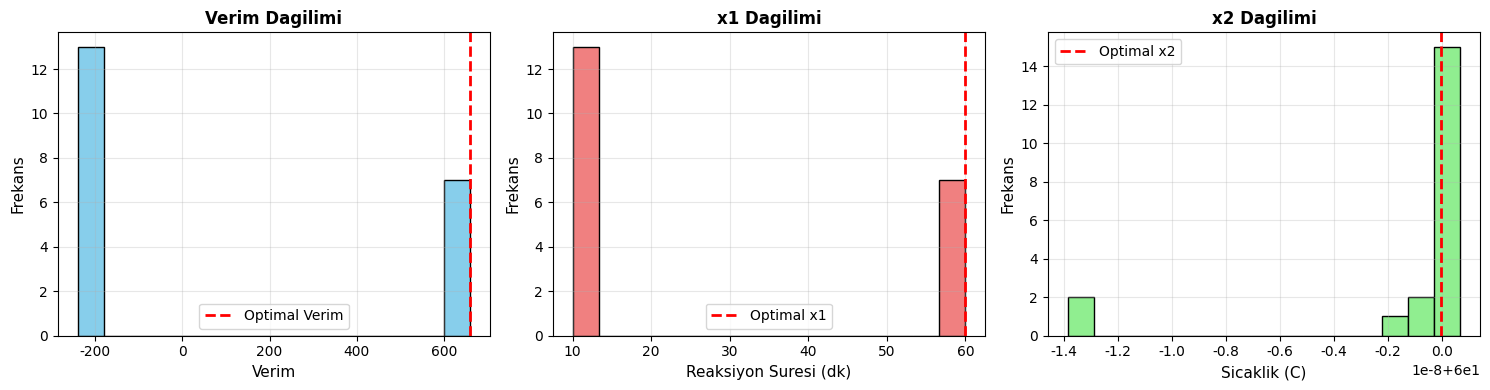

In [ ]:
# Rastgele başlangıç noktalarından optimizasyon yaparak sonucu doğrulama
np.random.seed(42)
n_trials = 20

results_list = []
for i in range(n_trials):
    # Rastgele başlangıç noktası
    x0_random = [
        np.random.uniform(10, 60),
        np.random.uniform(60, 120)
    ]

    # Optimizasyon
    result = minimize(
        objective_function_minimization,
        x0_random,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if result.success:
        results_list.append({
            'x1': result.x[0],
            'x2': result.x[1],
            'verim': -result.fun
        })

# Sonuçları DataFrame'e çevir
df_trials = pd.DataFrame(results_list)

print("Farklı Başlangıç Noktalarından Elde Edilen Sonuçlar:")
print("="*60)
print(f"Toplam deneme sayısı: {n_trials}")
print(f"Başarılı optimizasyon sayısı: {len(results_list)}")
print(f"\nBulunan en iyi verim: {df_trials['verim'].max():.4f}")
print(f"Bulunan en kötü verim: {df_trials['verim'].min():.4f}")
print(f"Ortalama verim: {df_trials['verim'].mean():.4f}")
print(f"Standart sapma: {df_trials['verim'].std():.4f}")

# En iyi 5 sonucu göster
print("\nEn İyi 5 Sonuç:")
print(df_trials.nlargest(5, 'verim').to_string(index=False))

# Sonuçların dağılımını görselleştir
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Verim dağılımı
axes[0].hist(df_trials['verim'], bins=15, color='skyblue', edgecolor='black')
axes[0].axvline(x=optimal_y, color='red', linestyle='--', linewidth=2, label='Optimal Verim')
axes[0].set_xlabel('Verim', fontsize=11)
axes[0].set_ylabel('Frekans', fontsize=11)
axes[0].set_title('Verim Dagilimi', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# x1 dağılımı
axes[1].hist(df_trials['x1'], bins=15, color='lightcoral', edgecolor='black')
axes[1].axvline(x=optimal_x1, color='red', linestyle='--', linewidth=2, label='Optimal x1')
axes[1].set_xlabel('Reaksiyon Suresi (dk)', fontsize=11)
axes[1].set_ylabel('Frekans', fontsize=11)
axes[1].set_title('x1 Dagilimi', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# x2 dağılımı
axes[2].hist(df_trials['x2'], bins=15, color='lightgreen', edgecolor='black')
axes[2].axvline(x=optimal_x2, color='red', linestyle='--', linewidth=2, label='Optimal x2')
axes[2].set_xlabel('Sicaklik (C)', fontsize=11)
axes[2].set_ylabel('Frekans', fontsize=11)
axes[2].set_title('x2 Dagilimi', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Pratik Öneriler ve Sonuç

In [ ]:
print("="*70)
print("KİMYA TESİSİ OPTİMİZASYONU")
print("="*70)

print("\n1. OPTİMAL ÇALIŞMA KOŞULLARI:")
print("-" * 70)
print(f"   • Reaksiyon Süresi (x1): {best_result.x[0]:.2f} dakika")
print(f"   • Sıcaklık (x2): {best_result.x[1]:.2f} derece C")
print(f"   • Beklenen Maksimum Verim: {-best_result.fun:.2f}")

print("\n2. KISIT DURUMU:")
print("-" * 70)
print(f"   • x1 + x2 ≤ 140: {best_result.x[0] + best_result.x[1]:.2f} ≤ 140 ✓")
print(f"   • x2 ≥ 60: {best_result.x[1]:.2f} ≥ 60 ✓")
print(f"   • 10 ≤ x1 ≤ 60: {best_result.x[0]:.2f} ✓")
print(f"   • 40 ≤ x2 ≤ 120: {best_result.x[1]:.2f} ✓")

print("\n3. PRATİK ÖNERİLER:")
print("-" * 70)
print(f"   a) Reaksiyon süresini {best_result.x[0]:.1f} ±2 dakika aralığında tutun.")
print(f"   b) Sıcaklığı {best_result.x[1]:.1f} ±3 derece C aralığında kontrol edin.")
print("   c) Optimal koşullardan sapma durumunda verim kayıpları beklenebilir.")
print("   d) Periyodik olarak proses parametrelerini izleyin ve ayarlayın.")

print("\n4. RİSK ANALİZİ:")
print("-" * 70)
print("   • Yüksek duyarlılık: Sıcaklık kontrolü kritik öneme sahiptir.")
print("   • Orta duyarlılık: Reaksiyon süresi toleransı nispeten daha geniştir.")
print("   • Kısıt ihlali: x1 + x2 > 140 durumunda sistem güvenliği tehlikeye girebilir.")

print("\n5. EKONOMİK DEĞERLENDIRME:")
print("-" * 70)
print(f"   • Optimal verim: {-best_result.fun:.2f} birim")
print(f"   • Toplam proses süresi: {best_result.x[0]:.2f} dakika")
print(f"   • Enerji maliyeti (sıcaklık): {best_result.x[1]:.2f} derece C")

print("\n" + "="*70)

KİMYA TESİSİ OPTİMİZASYONU

1. OPTİMAL ÇALIŞMA KOŞULLARI:
----------------------------------------------------------------------
   • Reaksiyon Süresi (x1): 60.00 dakika
   • Sıcaklık (x2): 60.00 derece C
   • Beklenen Maksimum Verim: 660.00

2. KISIT DURUMU:
----------------------------------------------------------------------
   • x1 + x2 ≤ 140: 120.00 ≤ 140 ✓
   • x2 ≥ 60: 60.00 ≥ 60 ✓
   • 10 ≤ x1 ≤ 60: 60.00 ✓
   • 40 ≤ x2 ≤ 120: 60.00 ✓

3. PRATİK ÖNERİLER:
----------------------------------------------------------------------
   a) Reaksiyon süresini 60.0 ±2 dakika aralığında tutun.
   b) Sıcaklığı 60.0 ±3 derece C aralığında kontrol edin.
   c) Optimal koşullardan sapma durumunda verim kayıpları beklenebilir.
   d) Periyodik olarak proses parametrelerini izleyin ve ayarlayın.

4. RİSK ANALİZİ:
----------------------------------------------------------------------
   • Yüksek duyarlılık: Sıcaklık kontrolü kritik öneme sahiptir.
   • Orta duyarlılık: Reaksiyon süresi toleransı n